In [4]:
import pandas as pd
import json
from transformers import AutoTokenizer
from datasets import load_dataset

In [15]:
def jaccard_similarity(L1, L2):
    return len(set(L1) & set(L2)) / len(set(L1) | set(L2))


In [14]:
tokenizer = AutoTokenizer.from_pretrained("rv2307/electra-small-ner")
data = load_dataset("xiaobendanyn/tacred", split = "test")
df = pd.DataFrame([json.loads(d['text']) for d in data]).map(lambda x: x['name'] if isinstance(x, dict) else " ".join(x) if isinstance(x, list) else x)
df.rename(columns = {"token": "input", "relation": "label"}, inplace = True)
df["h_tokens"] = df["h"].apply(lambda x: tokenizer.tokenize(x, add_special_tokens = False))
df["t_tokens"] = df["t"].apply(lambda x: tokenizer.tokenize(x, add_special_tokens = False))
df.head()

,input,h,t,label,h_tokens,t_tokens
0,The National Congress of American Indians was ...,National Congress of American Indians,1944,org:founded,"[national, congress, of, american, indians]",[1944]
1,UASR was founded in 1989 by Mousa abu Mazook <...,UASR,1989,org:founded,"[ua, ##sr]",[1989]
2,"Founded in 1951 , PATA is a non-profit members...",PATA,1951,org:founded,"[pat, ##a]",[1951]
3,The Securities and Exchange Commission schedul...,Countrywide,1969,org:founded,"[country, ##wide]",[1969]
4,"MEF , which was founded in 1991 , has grabbed ...",MEF,1991,org:founded,"[me, ##f]",[1991]


In [12]:
results = pd.read_json("../src/mbeer/entity_pairs_scores.json")
results["tokenized"] = results["original_text"].apply(lambda x: tokenizer.tokenize(x, add_special_tokens = False))
results["e_i_tokens"] = results.apply(lambda row: row["tokenized"][row["e_i_idx"][0]:row["e_i_idx"][1]], axis = 1)
results["e_j_tokens"] = results.apply(lambda row: row["tokenized"][row["e_j_idx"][0]:row["e_j_idx"][1]], axis = 1)
results = results.loc[results["e_j_tokens"].apply(len) > 1,:]
results.head()

,e_i_idx,e_j_idx,e_i_tokens,e_j_tokens,score,original_text,doc_number,tokenized
0,"[1, 2]","[7, 13]",[national],"[founded, in, 1944, in, response, to]",0.464947,The National Congress of American Indians was ...,1,"[the, national, congress, of, american, indian..."
20,"[4, 8]","[12, 14]","[in, 1994, ,, is]","[public, welfare]",0.473791,"The Federation , founded in 1994 , is a non-pr...",13,"[the, federation, ,, founded, in, 1994, ,, is,..."
22,"[9, 10]","[12, 14]",[non],"[public, welfare]",1.000000,"The Federation , founded in 1994 , is a non-pr...",13,"[the, federation, ,, founded, in, 1994, ,, is,..."
27,"[8, 10]","[18, 20]","[##usa, abu]","[www, ##in]",NaN,UASR was founded in 1989 by Mousa abu Mazook <...,17,"[ua, ##sr, was, founded, in, 1989, by, mo, ##u..."
29,"[1, 2]","[7, 13]",[securities],"[news, conference, thursday, in, washington, ,]",0.361280,The Securities and Exchange Commission schedul...,25,"[the, securities, and, exchange, commission, s..."


In [16]:
# Joint df and results on rows that have input==original_text and jaccard_similarity(h_tokens, e_i_tokens) >= 0.5 and jaccard_similarity(t_tokens, e_j_tokens) >= 0.5
jaccard_threshold = 0.333
all_scores = []
for i,row in results.iterrows():
    text_match = df.loc[df["input"] == row["original_text"]]
    if text_match.shape[0] > 0:
        h_match = text_match["h_tokens"].apply(lambda x: jaccard_similarity(x, row["e_i_tokens"]) >= jaccard_threshold)
        t_match = text_match["t_tokens"].apply(lambda x: jaccard_similarity(x, row["e_j_tokens"]) >= jaccard_threshold)
        both_matches = h_match & t_match
        if both_matches.any():
            match_scores = [(1,row["score"])]*sum(both_matches) + [(0,row["score"])]*(len(text_match)-sum(both_matches))
        else:
            match_scores = [(0,row["score"])]*len(text_match)
    all_scores.extend(match_scores)

y_true             0           1
count   12536.000000  162.000000
mean        0.544805    0.588870
std         0.373619    0.371754
min         0.000000    0.000000
25%         0.174605    0.316167
50%         0.598990    0.623421
75%         0.912342    1.000000
max         1.000000    1.000000


<Axes: >

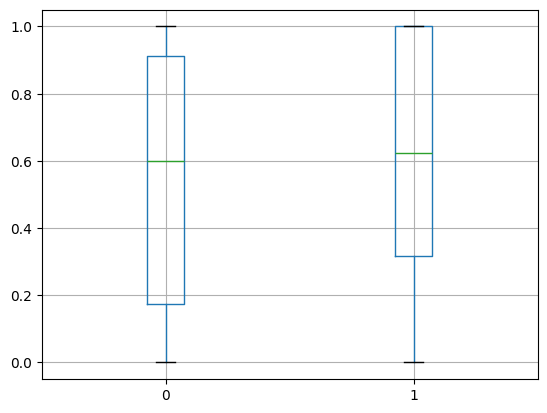

In [26]:
pivot_table = pd.DataFrame(all_scores, columns = ["y_true", "y_pred"]).pivot(columns = "y_true", values = "y_pred")
print(pivot_table.describe())
pivot_table.boxplot()

In [27]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("numind/NuNER-v2.0")
model

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at numind/NuNER-v2.0 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            